In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import serial
import csv
import time
import json
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt

Chirp adalah sinyal sinusoidal yang frekuesinya naik secara linear sesuai dengan waktu, bisa juga dikatakan bahwa chirp itu adalah continues waves yang mana frekuensinya secara linear termodulasi 

In [107]:
# Function to read data from the serial port and save to CSV
def read_serial_to_csv(port, baudrate, csv_filename, duration):
    # Open the serial port
    ser = serial.Serial(port, baudrate, timeout=1)
    
    # Open the CSV file for writing
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(["I", "Q"])
        
        # Record the start time
        start_time = time.time()
        
        # Buffers for I and Q components
        I_buffer = []
        Q_buffer = []
        
        # Loop to read data for the specified duration
        while time.time() - start_time < duration:
            # Read a line from the serial port
            line = ser.readline().decode('utf-8').strip()
            
            if line:
                try:
                    # Parse the JSON data
                    data = json.loads(line)
                    if isinstance(data, dict):
                        if "I" in data:
                            I_buffer = data["I"]
                        if "Q" in data:
                            Q_buffer = data["Q"]
                    
                    # Check if both buffers have data
                    if I_buffer and Q_buffer:
                        if len(I_buffer) == len(Q_buffer):
                            for I, Q in zip(I_buffer, Q_buffer):
                                # Write the I and Q values to the CSV file
                                writer.writerow([I, Q])
                            print(f"Written {len(I_buffer)} pairs of I and Q values.")
                            
                            # Clear the buffers after writing to CSV
                            I_buffer.clear()
                            Q_buffer.clear()
                        else:
                            print(f"Mismatched lengths: I={len(I_buffer)}, Q={len(Q_buffer)}")
                except json.JSONDecodeError:
                    print(f"Invalid JSON data: {line}")
                except TypeError as e:
                    print(f"TypeError: {e} - Data: {line}")
            time.sleep(0.01)  # Sleep for a short time to avoid busy-waiting
                
        # Close the serial port
        ser.close()
        print(f"Data logging stopped after {duration} seconds.")

# Parameters for the serial port and CSV file
serial_port = 'COM21'  # Replace with your serial port
baud_rate = 115200      # Replace with your baud rate
csv_file = 'radar_data.csv'
duration_seconds = 10  # Read data for 5 seconds

# Start reading data from the serial port and saving to CSV
read_serial_to_csv(serial_port, baud_rate, csv_file, duration_seconds)


Invalid JSON data: 2043,2043,2033,2007,2050,2041,2037,2051,2041,2052,2053,2075,2059,2055,2055,2065,2065,2038,2055,2041,2061,2053,2059,2062,2035,2033,2057,2022,2041,2071,2074,2033,2027,2023,2011,2021,2041,2050,2045,2025,2077,2055,2033,2032,2041,2031,2041,2059,2061,2069,2027,2045,2033,2071,2061,2039,2042,2061,2045,2063,2019,2033,2041,2040,2033,2065,2049,2051,2049,2081,2027,2041,2033,2043,2053,2063,2037,2043,2061,2050,2037,2057,2025,2041,2031,2035,2045,2037,2066,2039,2041,2039,2039,2058,2043,2033,2049,2041,2033,2053,2053,2037,2063,2079,2063,2029,2029,2027,2071,2045,2043,2017,2043,2051,2011,2045,2043,2045,2057,2035,2063,2033,2044,2065,2063,2041,2049,2061,2025,2056,2029,2057,2027,2041,2059,2041,2057,2043,2031,2037,2053,2045,2068,2033,2037,2039,2039,2039,2069,2023,2031,2039,2031,2041,2053,2007,2057,2033,2045,2054,2064,2035,2057,2057,2039,2057,2045,2049,2008,2044,2044,2037,2041,2045,2039,2033]}
Written 512 pairs of I and Q values.
Written 512 pairs of I and Q values.
Written 512 pairs of I an

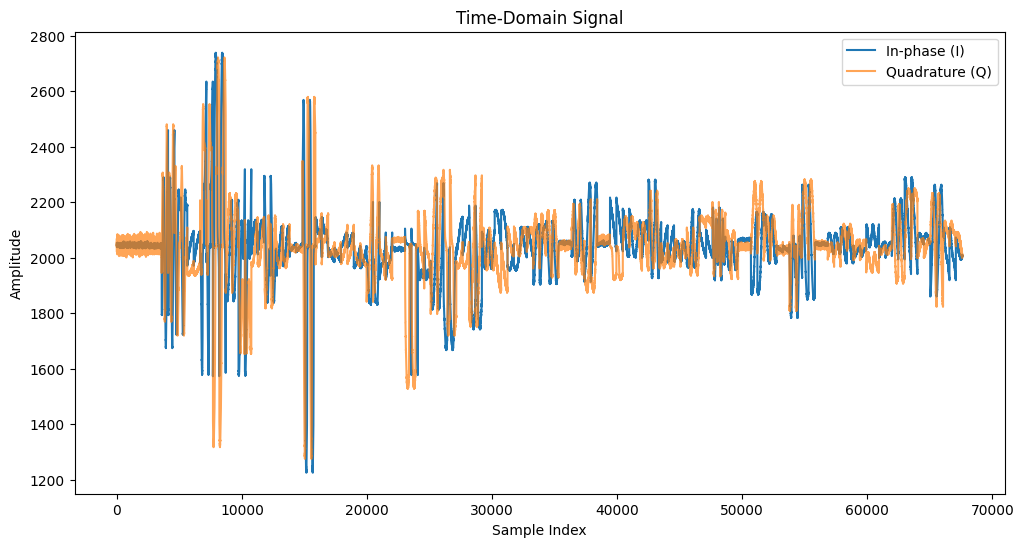

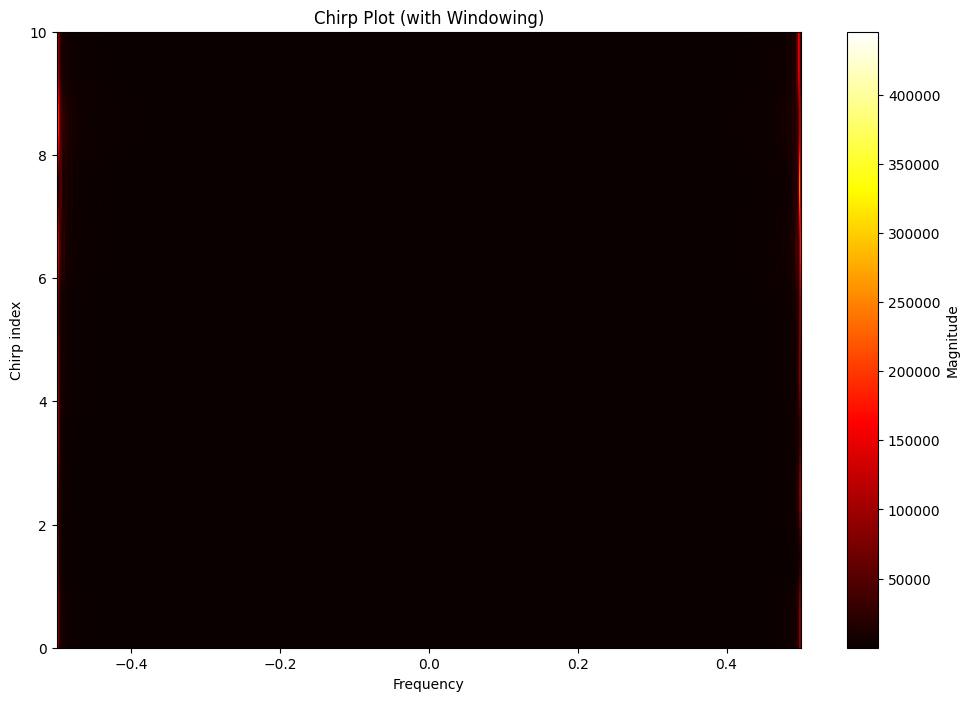

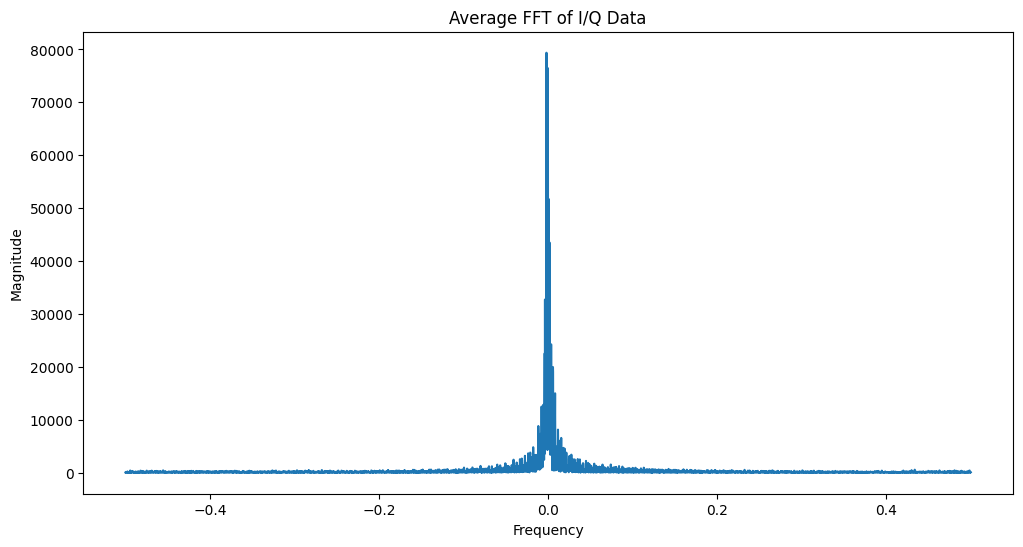

In [108]:
data = pd.read_csv('radar_data.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Compute the complex signal
s = I + 1j * Q

# Remove the mean to center the data
s = s - np.mean(s)

# Number of samples per chirp (you need to provide this value or calculate it)
num_chirps = 10  # Adjust this value as needed
num_samples_per_chirp = len(s) // num_chirps

# Reshape the complex signal into a 2D array
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Apply a window function (e.g., Hanning window) to reduce spectral leakage
window = np.hanning(num_samples_per_chirp)
s_windowed = s * window

# Apply the FFT along the columns (for each chirp)
range_spectrum = np.fft.fft(s_windowed, axis=1)

# Plot the time-domain signal (I and Q components)
plt.figure(figsize=(12, 6))
plt.plot(I, label='In-phase (I)')
plt.plot(Q, label='Quadrature (Q)',alpha = 0.7)
plt.legend()
plt.title('Time-Domain Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
# Plot the absolute value of the range spectrum
plt.figure(figsize=(12, 8))
plt.imshow(np.abs(range_spectrum), aspect='auto', cmap='hot', extent=[-0.5, 0.5, 0, num_chirps])
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency')
plt.ylabel('Chirp index')
plt.title('Chirp Plot (with Windowing)')
plt.show()

# Plot the average spectrum across all chirps
plt.figure(figsize=(12, 6))
plt.plot(np.fft.fftshift(np.fft.fftfreq(num_samples_per_chirp)), np.fft.fftshift(np.abs(np.mean(range_spectrum, axis=0))))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Average FFT of I/Q Data')
plt.show()

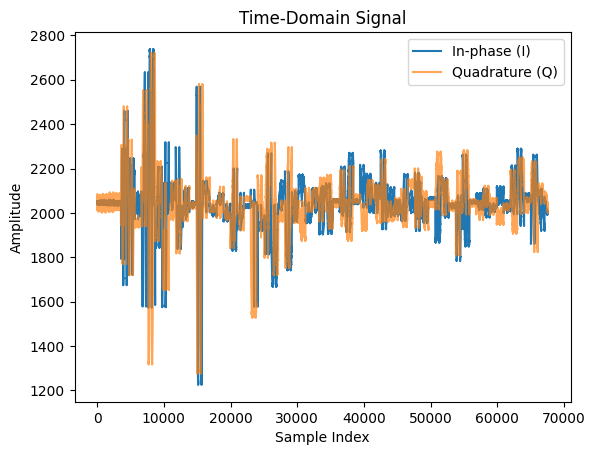

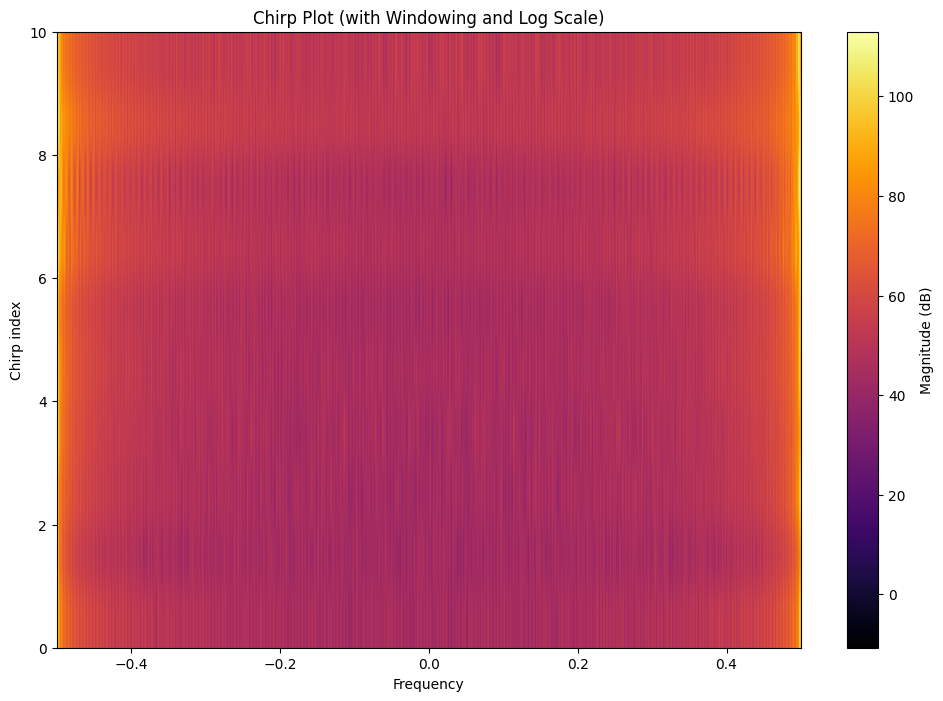

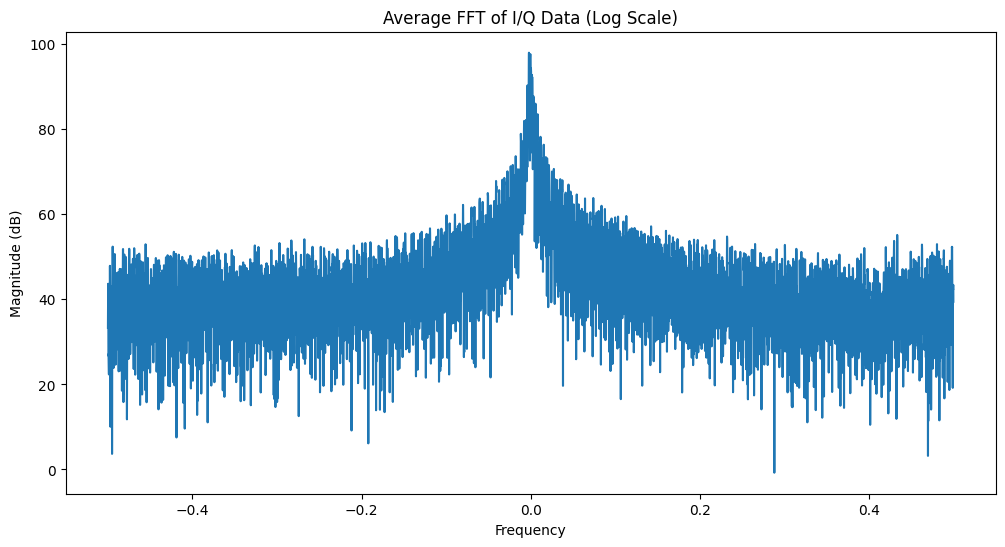

In [109]:
data = pd.read_csv('radar_data.csv')


# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Compute the complex signal
s = I + 1j * Q

# Remove the mean to center the data
s = s - np.mean(s)

# Number of samples per chirp (you need to provide this value or calculate it)
num_chirps = 10  # Adjust this value as needed
num_samples_per_chirp = len(s) // num_chirps

# Reshape the complex signal into a 2D array
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Apply a window function (e.g., Hanning window) to reduce spectral leakage
window = np.hanning(num_samples_per_chirp)
s_windowed = s * window

# Apply the FFT along the columns (for each chirp)
range_spectrum = np.fft.fft(s_windowed, axis=1)


plt.plot(I, label='In-phase (I)')
plt.plot(Q, label='Quadrature (Q)',alpha = 0.7)
plt.legend()
plt.title('Time-Domain Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

# Plot the absolute value of the range spectrum in logarithmic scale
plt.figure(figsize=(12, 8))
plt.imshow(20 * np.log10(np.abs(range_spectrum) + 1e-6), aspect='auto', cmap='inferno', extent=[-0.5, 0.5, 0, num_chirps])
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Frequency')
plt.ylabel('Chirp index')
plt.title('Chirp Plot (with Windowing and Log Scale)')
plt.show()

# Plot the average spectrum across all chirps in logarithmic scale
plt.figure(figsize=(12, 6))
plt.plot(np.fft.fftshift(np.fft.fftfreq(num_samples_per_chirp)), 20 * np.log10(np.fft.fftshift(np.abs(np.mean(range_spectrum, axis=0))) + 1e-6))
plt.xlabel('Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('Average FFT of I/Q Data (Log Scale)')
plt.show()

Chirp 1 data: [10.24501361 +1.50390625j 11.24501361 +0.50390625j
 11.24501361+25.50390625j 13.24501361 +3.50390625j
 10.24501361 -3.49609375j  3.24501361+27.50390625j
 10.24501361-16.49609375j  7.24501361+17.50390625j
  6.24501361 +7.50390625j  6.24501361-20.49609375j
  4.24501361+14.50390625j  7.24501361 +3.50390625j
  5.24501361 -0.49609375j 10.24501361+11.50390625j
  8.24501361 -5.49609375j  5.24501361+17.50390625j
 10.24501361 -4.49609375j  5.24501361+17.50390625j
  3.24501361 +1.50390625j  4.24501361+13.50390625j
 12.24501361 -6.49609375j 15.24501361 -0.49609375j
  3.24501361 -0.49609375j  5.24501361-12.49609375j
  1.24501361+17.50390625j  7.24501361+27.50390625j
  5.24501361+11.50390625j  7.24501361+23.50390625j
  7.24501361 -8.49609375j 10.24501361 -4.49609375j
  5.24501361 -8.49609375j  5.24501361-21.49609375j
 11.24501361-10.49609375j 11.24501361-21.49609375j
 11.24501361-12.49609375j 10.24501361-10.49609375j
 11.24501361+15.50390625j 13.24501361 +1.50390625j
  5.24501361+13.5

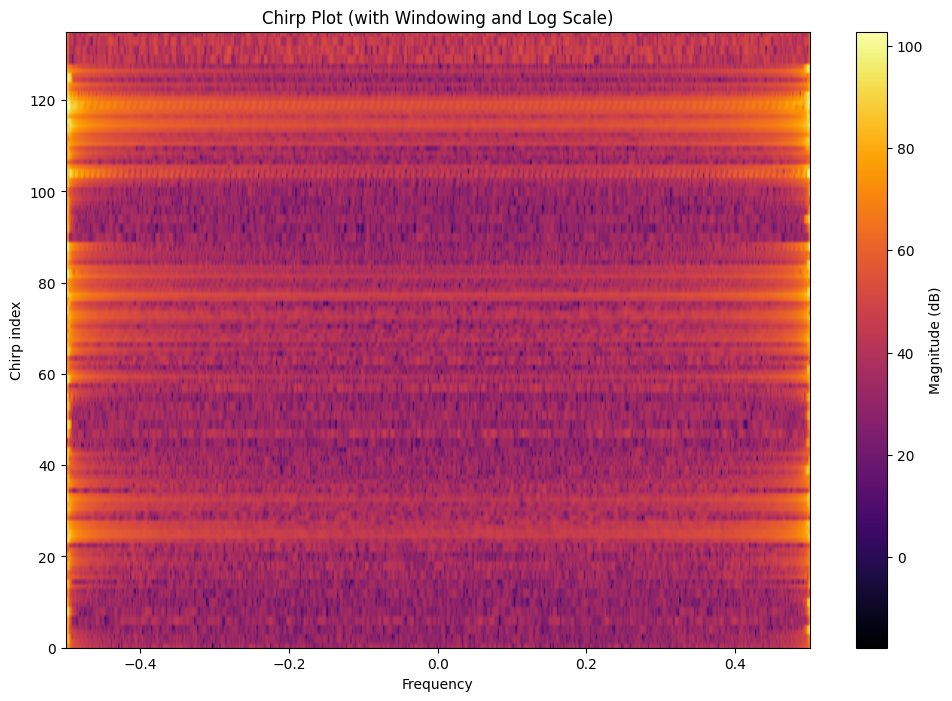

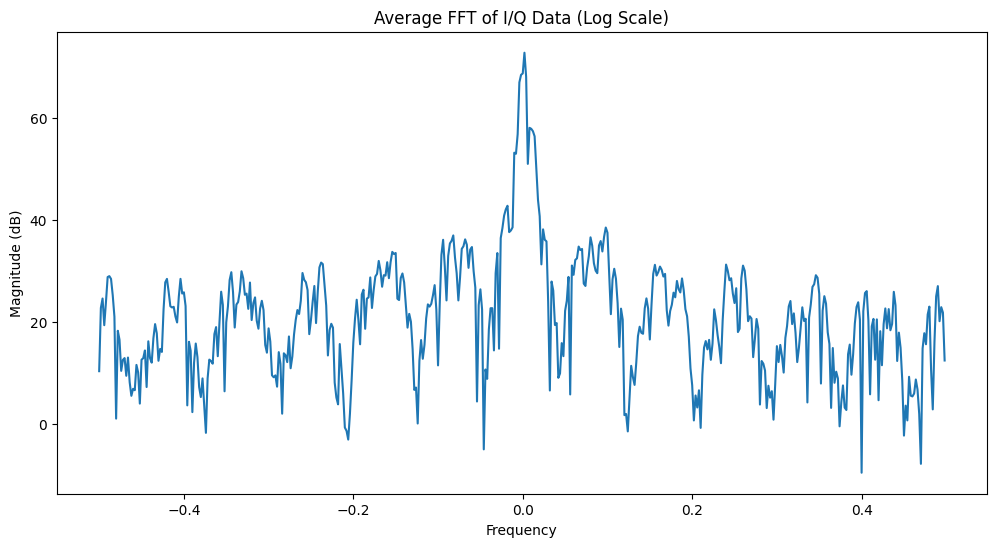

In [110]:
data = pd.read_csv('radar_data.csv')


# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Compute the complex signal
s = I + 1j * Q
# Remove the mean to center the data
s = s - np.mean(s)

# Radar parameters
bandwidth_MHz = 220.000
ramp_down_time_usec = 500  # in microseconds

# Sampling rate (assumed to be 1 MHz)
sampling_rate_Hz = 1e6  # 1 MHz

# Calculate the number of samples per chirp
num_samples_per_chirp = int(sampling_rate_Hz * ramp_down_time_usec / 1e6)

# Determine the number of chirps in the dataset
num_chirps = len(s) // num_samples_per_chirp

# Reshape the complex signal into a 2D array (each row is a chirp)
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Each row of s now represents a single chirp
for i in range(num_chirps):
    chirp_data = s[i, :]
    print(f'Chirp {i + 1} data:', chirp_data)

# Apply a window function (e.g., Hanning window) to reduce spectral leakage
window = np.hanning(num_samples_per_chirp)
s_windowed = s * window

# Apply the FFT along the columns (for each chirp)
range_spectrum = np.fft.fft(s_windowed, axis=1)

# Plot the absolute value of the range spectrum in logarithmic scale
plt.figure(figsize=(12, 8))
plt.imshow(20 * np.log10(np.abs(range_spectrum) + 1e-6), aspect='auto', cmap='inferno', extent=[-0.5, 0.5, 0, num_chirps])
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Frequency')
plt.ylabel('Chirp index')
plt.title('Chirp Plot (with Windowing and Log Scale)')
plt.show()

# Plot the average spectrum across all chirps in logarithmic scale
plt.figure(figsize=(12, 6))
plt.plot(np.fft.fftshift(np.fft.fftfreq(num_samples_per_chirp)), 20 * np.log10(np.fft.fftshift(np.abs(np.mean(range_spectrum, axis=0))) + 1e-6))
plt.xlabel('Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('Average FFT of I/Q Data (Log Scale)')
plt.show()

Chirp 1 data: [-0.81262807 -2.77426998j -5.81262807-10.77426998j
  0.18737193 +3.22573002j -3.81262807 -0.77426998j
  0.18737193 +5.22573002j -3.81262807 -9.77426998j
 -2.81262807 -4.77426998j  1.18737193 +3.22573002j
 -2.81262807 -4.77426998j  3.18737193 +5.22573002j
  6.18737193+11.22573002j -8.81262807-16.77426998j
 -0.81262807 +3.22573002j  3.18737193 +5.22573002j
  1.18737193 +4.22573002j  1.18737193 +5.22573002j
  0.18737193 +9.22573002j  3.18737193 +8.22573002j
  3.18737193 -0.77426998j -2.81262807 -8.77426998j
  5.18737193+14.22573002j -1.81262807 -6.77426998j
 -8.81262807-16.77426998j  0.18737193 -6.77426998j
 -0.81262807 -7.77426998j  0.18737193 +7.22573002j
  0.18737193 -4.77426998j  1.18737193 -3.77426998j
 -0.81262807 -3.77426998j  1.18737193 -0.77426998j
 -1.81262807 -6.77426998j -0.81262807 -2.77426998j
 -1.81262807 -8.77426998j -1.81262807 -3.77426998j
 -2.81262807 -8.77426998j -1.81262807 -9.77426998j
  4.18737193 +3.22573002j -0.81262807 -6.77426998j
 -1.81262807-12.7

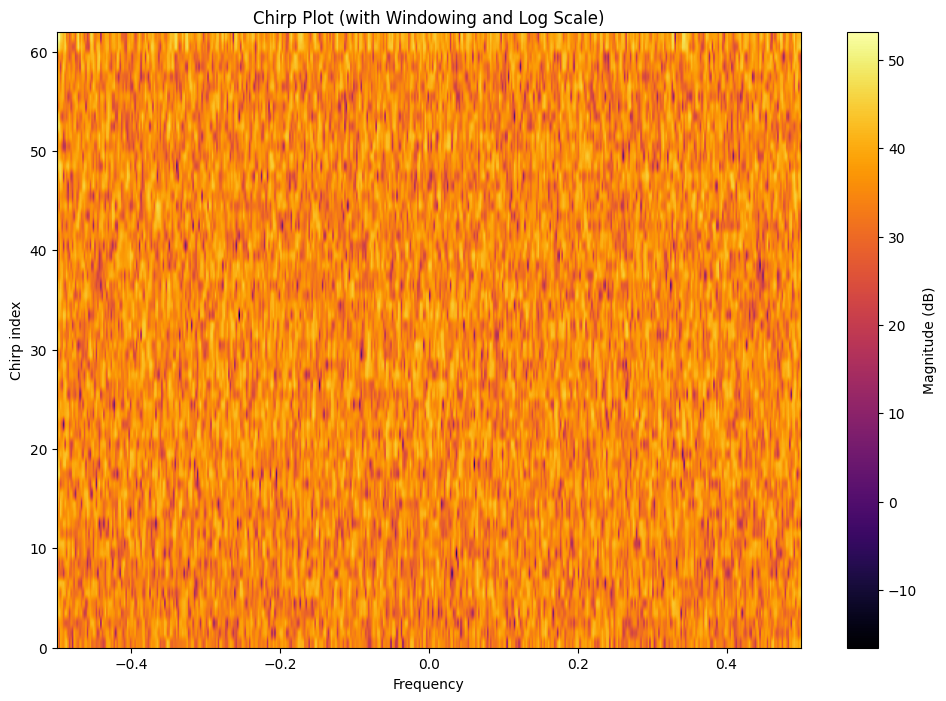

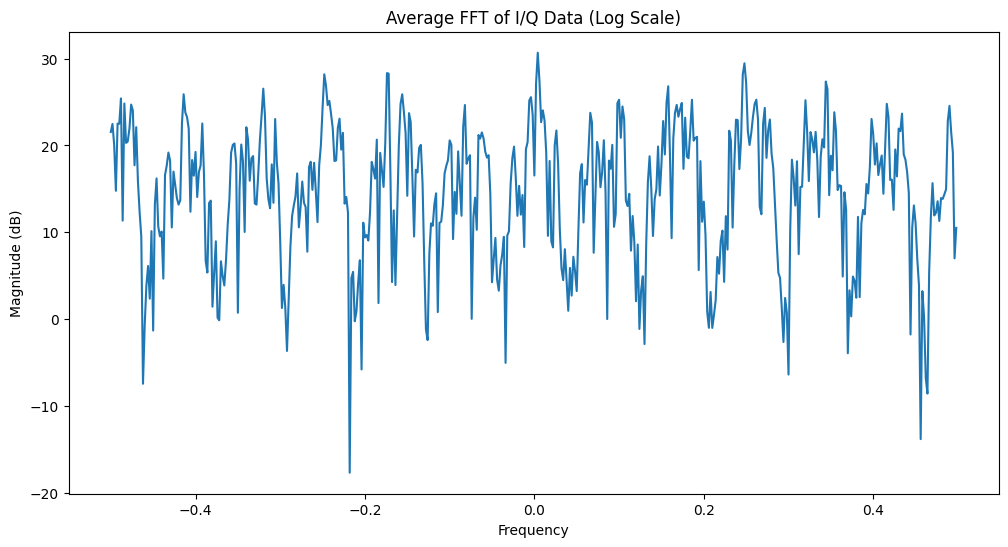

In [106]:
data = pd.read_csv('radar_data2.csv')


# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Compute the complex signal
s = I + 1j * Q
# Remove the mean to center the data
s = s - np.mean(s)

# Radar parameters
bandwidth_MHz = 220.000
ramp_down_time_usec = 500  # in microseconds

# Sampling rate (assumed to be 1 MHz)
sampling_rate_Hz = 1e6 # 1 MHz

# Calculate the number of samples per chirp
num_samples_per_chirp = int(sampling_rate_Hz * ramp_down_time_usec / 1e6)

# Determine the number of chirps in the dataset
num_chirps = len(s) // num_samples_per_chirp

# Reshape the complex signal into a 2D array (each row is a chirp)
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Each row of s now represents a single chirp
for i in range(num_chirps):
    chirp_data = s[i, :]
    print(f'Chirp {i + 1} data:', chirp_data)

# Apply a window function (e.g., Hanning window) to reduce spectral leakage
window = np.hanning(num_samples_per_chirp)
s_windowed = s * window

# Apply the FFT along the columns (for each chirp)
range_spectrum = np.fft.fft(s_windowed, axis=1)

# Plot the absolute value of the range spectrum in logarithmic scale
plt.figure(figsize=(12, 8))
plt.imshow(20 * np.log10(np.abs(range_spectrum) + 1e-6), aspect='auto', cmap='inferno', extent=[-0.5, 0.5, 0, num_chirps])
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Frequency')
plt.ylabel('Chirp index')
plt.title('Chirp Plot (with Windowing and Log Scale)')
plt.show()

# Plot the average spectrum across all chirps in logarithmic scale
plt.figure(figsize=(12, 6))
plt.plot(np.fft.fftshift(np.fft.fftfreq(num_samples_per_chirp)), 20 * np.log10(np.fft.fftshift(np.abs(np.mean(range_spectrum, axis=0))) + 1e-6))
plt.xlabel('Frequency')
plt.ylabel('Magnitude (dB)')
plt.title('Average FFT of I/Q Data (Log Scale)')
plt.show()

nilai magntude spectrum sinyal :  [1.99933697e+08 1.73680391e+04 1.37090838e+04 ... 1.68789211e+04
 1.47283998e+04 9.01704588e+03]
nilai domain frequency sinyal :  [ 0.00000000e+00  1.44675926e-05  2.89351852e-05 ... -4.34027778e-05
 -2.89351852e-05 -1.44675926e-05]
nilai sinyal [2045.+2049.j 2038.+2045.j 2040.+2041.j ... 2057.+2043.j 2065.+2049.j
 2053.+2041.j]


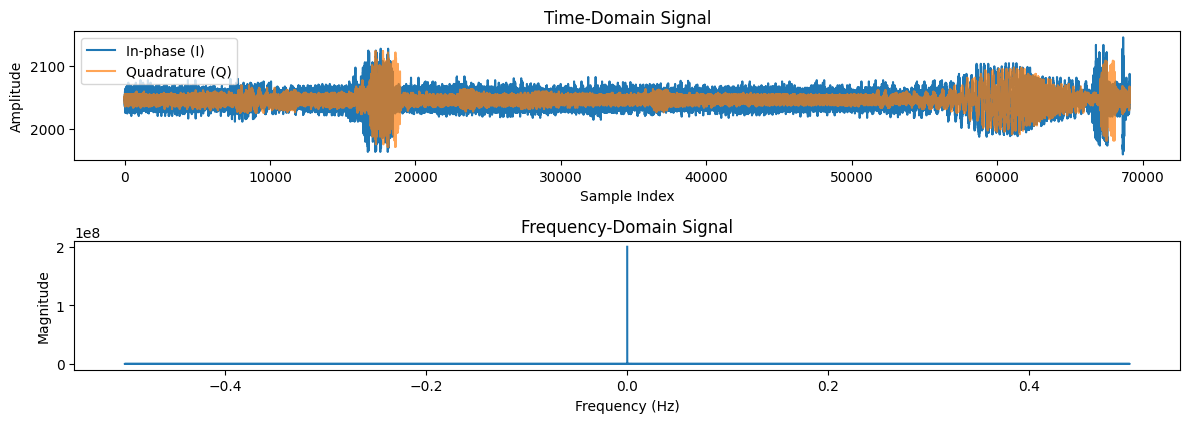

In [21]:
# Load the data from the CSV file
data = pd.read_csv('radar_data5.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Convert to complex signal
signal = I + 1j * Q

# Perform Fourier Transform
fft_signal = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal))

# Get the magnitude spectrum
magnitude_spectrum = np.abs(fft_signal)

# Plot the time-domain signal (I and Q components)
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(I, label='In-phase (I)')
plt.plot(Q, label='Quadrature (Q)',alpha = 0.7)
plt.legend()
plt.title('Time-Domain Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

print("nilai magntude spectrum sinyal : ",magnitude_spectrum)
print("nilai domain frequency sinyal : ",fft_freqs)
print("nilai sinyal",signal)
# Plot the frequency-domain signal
plt.subplot(3, 1, 2)
plt.plot(fft_freqs,magnitude_spectrum)
plt.title('Frequency-Domain Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

Mean of Magnitude: 13381.10947786162
Standard Deviation of Magnitude: 540380.2091473571
Mean of Phase: -1.4361213235294322e-05
Standard Deviation of Phase: 0.28867513447573756
Standard Deviation of fft_result: 5247769.92334258
nilai magntude spectrum sinyal :  [1.00724088e+08 4.22160204e+04 4.87751074e+04 ... 1.25342241e+04
 1.68672102e+04 9.65621689e+03]
nilai domain frequency sinyal :  [ 0.00000000e+00  2.87224265e-05  5.74448529e-05 ... -8.61672794e-05
 -5.74448529e-05 -2.87224265e-05]
nilai sinyal [2058.+1885.j 2054.+1881.j 2044.+1881.j ... 2042.+2043.j 2039.+2033.j
 2041.+2035.j]
nilai fft result [4.65876708e+08      +0.j         3.68734183e+08 -596945.22057724j
 3.03388256e+08 -864867.45379259j ... 2.63617021e+08+1206334.10095868j
 3.03388256e+08 +864867.45379259j 3.68734183e+08 +596945.22057724j]


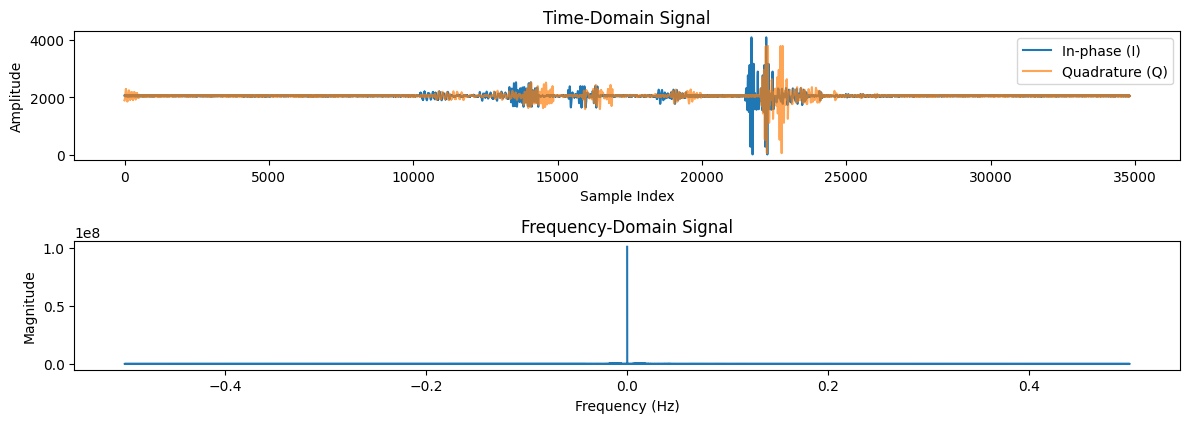

d:\TA\KALIBRASI\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\TA\KALIBRASI\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


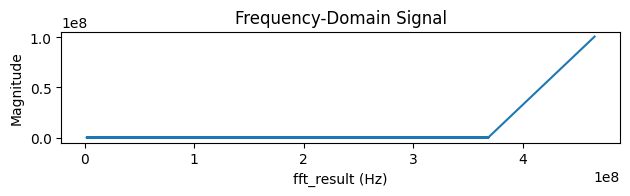

In [32]:
# Load the data from the CSV file
data = pd.read_csv('radar_data1.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Convert to complex signal
signal = I + 1j * Q

# Perform Fourier Transform
fft_signal = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal))

# Get the magnitude spectrum
magnitude_spectrum = np.abs(fft_signal)
fft_result = np.fft.fft(magnitude_spectrum)
# Print the mean and standard deviation of magnitude and phase
print(f"Mean of Magnitude: {np.mean(magnitude_spectrum)}")
print(f"Standard Deviation of Magnitude: {np.std(magnitude_spectrum)}")
print(f"Mean of Phase: {np.mean(fft_freqs)}")
print(f"Standard Deviation of Phase: {np.std(fft_freqs)}")
print(f"Standard Deviation of fft_result: {np.std(fft_result)}")
# Plot the time-domain signal (I and Q components)
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(I, label='In-phase (I)')
plt.plot(Q, label='Quadrature (Q)',alpha = 0.7)
plt.legend()
plt.title('Time-Domain Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')

print("nilai magntude spectrum sinyal : ",magnitude_spectrum)
print("nilai domain frequency sinyal : ",fft_freqs)
print("nilai sinyal",signal)
print("nilai fft result",fft_result)
# Plot the frequency-domain signal
plt.subplot(3, 1, 2)
plt.plot(fft_freqs,magnitude_spectrum)
plt.title('Frequency-Domain Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

plt.subplot(3, 1, 2)
plt.plot(fft_result,magnitude_spectrum)
plt.title('Frequency-Domain Signal')
plt.xlabel('fft_result (Hz)')
plt.ylabel('Magnitude')
plt.tight_layout()
plt.show()

nilai phase [0.74155106 0.74146203 0.74389335 ... 0.78564296 0.78392469 0.78392613]
nilai fase dengan fft [ 1.00795857e+08    +0.j         -6.37439266e+04+29628.05242636j
  1.65758755e+04-29545.15316018j ...  3.11460735e+04-12366.87711593j
  1.65758755e+04+29545.15316018j -6.37439266e+04-29628.05242636j]


d:\TA\KALIBRASI\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\TA\KALIBRASI\.venv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


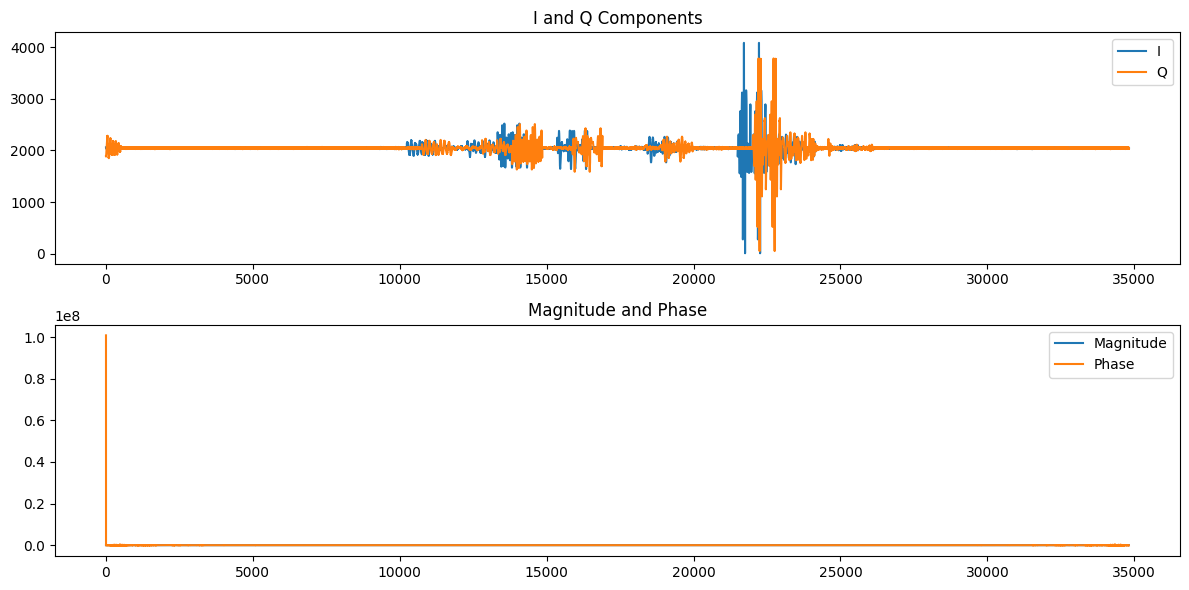

Mean of Magnitude: 2895.1015842368124
Standard Deviation of Magnitude: 103.86321503678974
Mean of Phase: 0.7856229869720702
Standard Deviation of Phase: 0.03947970284300457


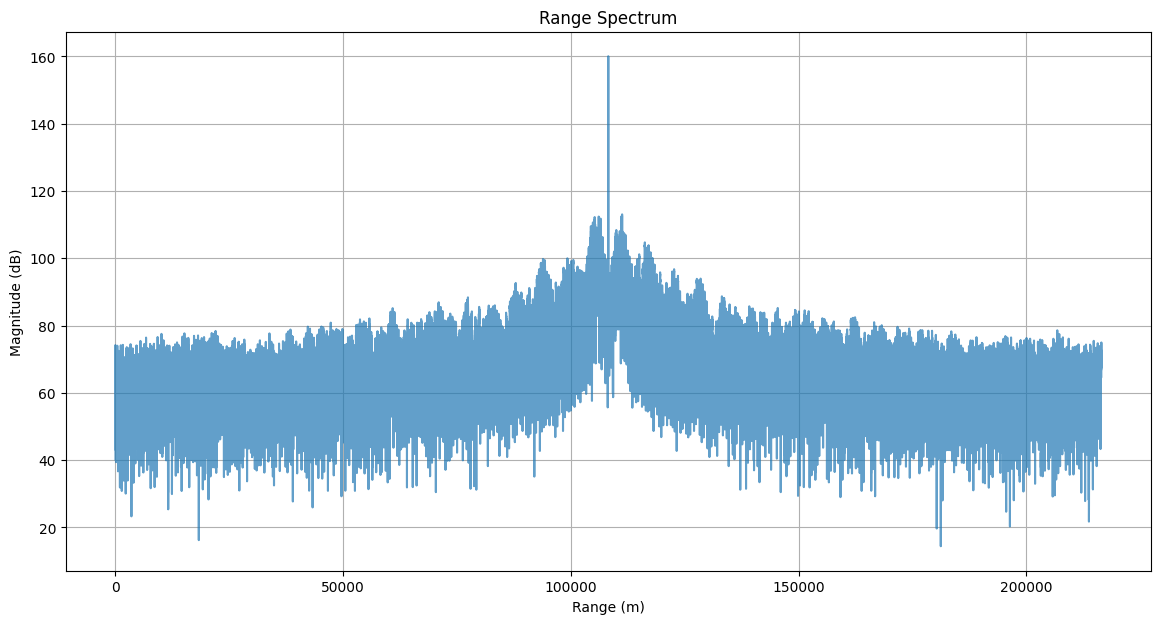

In [39]:
data = pd.read_csv('radar_data1.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values


# Compute the complex signal from the I and Q components
complex_signal = I + 1j*Q

# Perform FFT on the complex signal to get the range spectrum
range_spectrum = np.fft.fftshift(np.fft.fft(complex_signal))

# Compute the range bin (assuming a certain radar configuration)
c = 3e8  # Speed of light
B = 24.125e9  # Bandwidth of the FMCW signal
T = 1e-3  # Sweep time
N = len(complex_signal)  # Number of samples
range_bin = c * B * np.arange(N) / (2 * B**2 * T)

# Plot the range spectrum
plt.figure(figsize=(14, 7))
plt.plot(range_bin, 20*np.log10(np.abs(range_spectrum)),alpha = 0.7)
plt.title('Range Spectrum')
plt.xlabel('Range (m)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

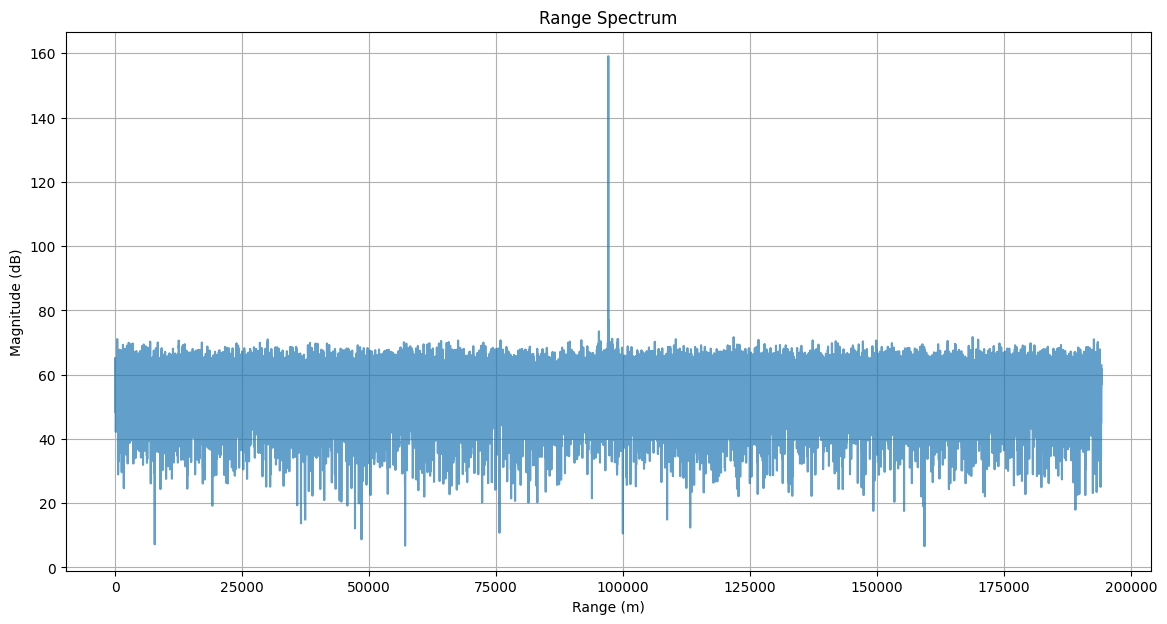

In [40]:
data = pd.read_csv('radar_data2.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values


# Compute the complex signal from the I and Q components
complex_signal = I + 1j*Q

# Perform FFT on the complex signal to get the range spectrum
range_spectrum = np.fft.fftshift(np.fft.fft(complex_signal))

# Compute the range bin (assuming a certain radar configuration)
c = 3e8  # Speed of light
B = 24.125e9  # Bandwidth of the FMCW signal
T = 1e-3  # Sweep time
N = len(complex_signal)  # Number of samples
range_bin = c * B * np.arange(N) / (2 * B**2 * T)

# Plot the range spectrum
plt.figure(figsize=(14, 7))
plt.plot(range_bin, 20*np.log10(np.abs(range_spectrum)),alpha = 0.7)
plt.title('Range Spectrum')
plt.xlabel('Range (m)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

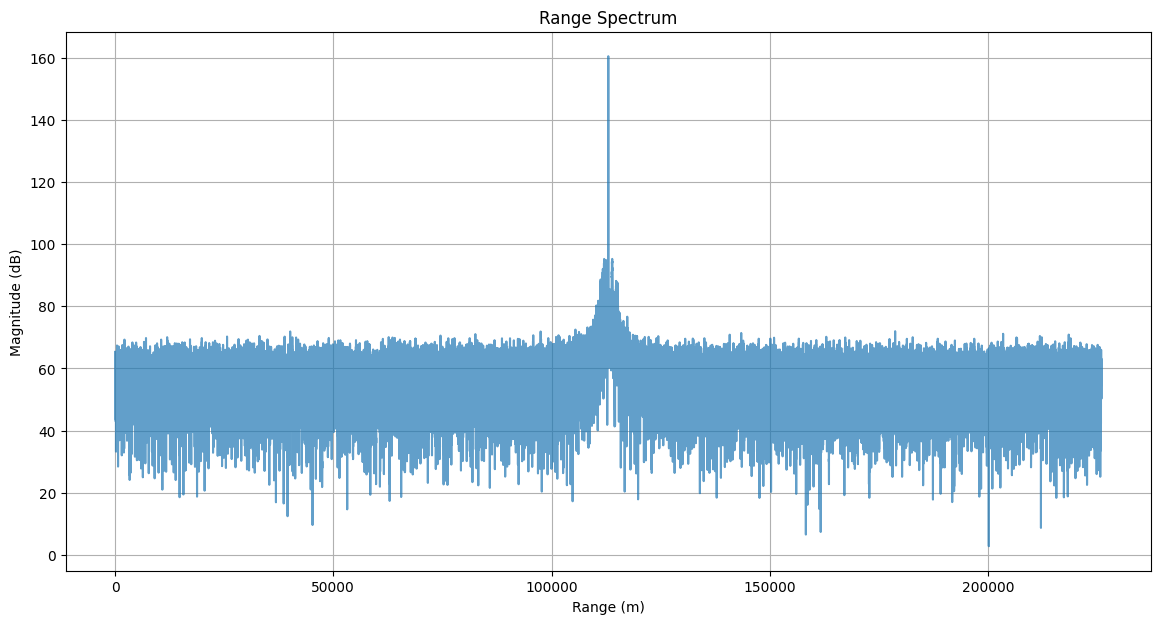

In [41]:
data = pd.read_csv('radar_data3.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values


# Compute the complex signal from the I and Q components
complex_signal = I + 1j*Q

# Perform FFT on the complex signal to get the range spectrum
range_spectrum = np.fft.fftshift(np.fft.fft(complex_signal))

# Compute the range bin (assuming a certain radar configuration)
c = 3e8  # Speed of light
B = 24.125e9  # Bandwidth of the FMCW signal
T = 1e-3  # Sweep time
N = len(complex_signal)  # Number of samples
range_bin = c * B * np.arange(N) / (2 * B**2 * T)

# Plot the range spectrum
plt.figure(figsize=(14, 7))
plt.plot(range_bin, 20*np.log10(np.abs(range_spectrum)),alpha = 0.7)
plt.title('Range Spectrum')
plt.xlabel('Range (m)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

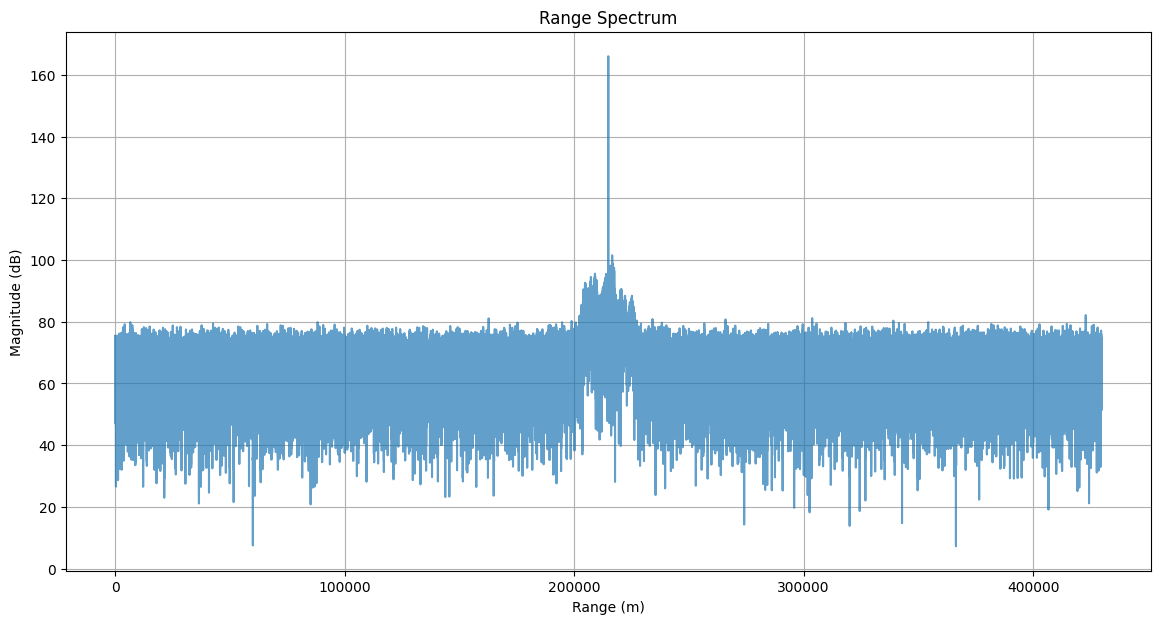

In [42]:
data = pd.read_csv('radar_data5.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values


# Compute the complex signal from the I and Q components
complex_signal = I + 1j*Q

# Perform FFT on the complex signal to get the range spectrum
range_spectrum = np.fft.fftshift(np.fft.fft(complex_signal))

# Compute the range bin (assuming a certain radar configuration)
c = 3e8  # Speed of light
B = 24.125e9  # Bandwidth of the FMCW signal
T = 1e-3  # Sweep time
N = len(complex_signal)  # Number of samples
range_bin = c * B * np.arange(N) / (2 * B**2 * T)

# Plot the range spectrum
plt.figure(figsize=(14, 7))
plt.plot(range_bin, 20*np.log10(np.abs(range_spectrum)),alpha = 0.7)
plt.title('Range Spectrum')
plt.xlabel('Range (m)')
plt.ylabel('Magnitude (dB)')
plt.grid(True)
plt.show()

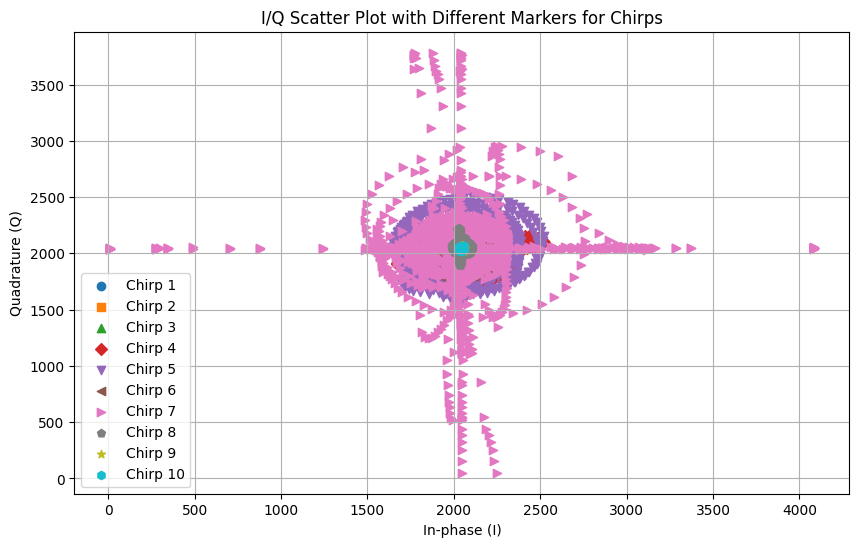

In [67]:
# Load the data from the CSV file
data = pd.read_csv('radar_data1.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values
s = I + 1j * Q
# Compute the complex signal
# Number of samples per chirp (you need to provide this value or calculate it)
num_chirps =10  # Adjust this value as needed

num_samples_per_chirp = len(s) // num_chirps

# Reshape the complex signal into a 2D array
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Define markers for different chirps
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

# Plot the I/Q data for each chirp with different markers
plt.figure(figsize=(10, 6))
for chirp_idx in range(num_chirps):
    plt.scatter(np.real(s[chirp_idx]), np.imag(s[chirp_idx]), marker=markers[chirp_idx % len(markers)], label=f'Chirp {chirp_idx+1}')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('I/Q Scatter Plot with Different Markers for Chirps')
plt.legend()
plt.grid(True)
plt.show()

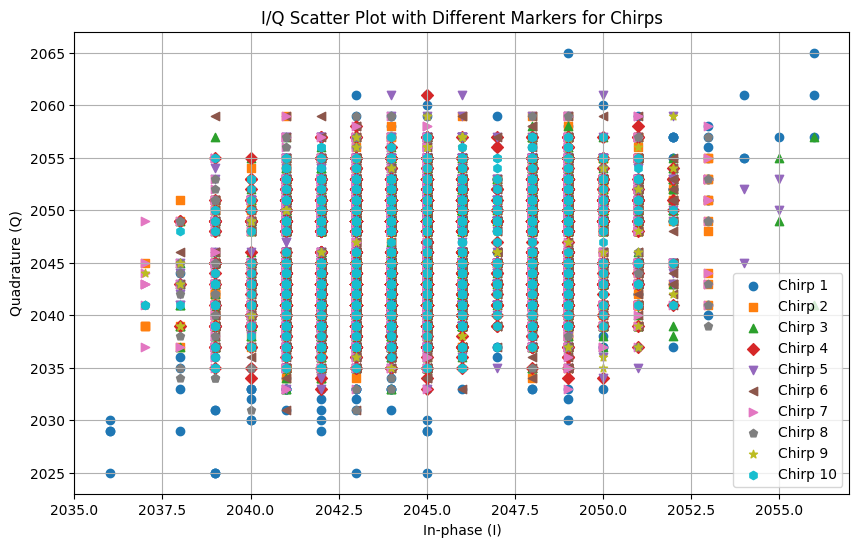

In [66]:
# Load the data from the CSV file
data = pd.read_csv('radar_data2.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values
s = I + 1j * Q
# Compute the complex signal
# Number of samples per chirp (you need to provide this value or calculate it)
num_chirps =10  # Adjust this value as needed

num_samples_per_chirp = len(s) // num_chirps

# Reshape the complex signal into a 2D array
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Define markers for different chirps
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

# Plot the I/Q data for each chirp with different markers
plt.figure(figsize=(10, 6))
for chirp_idx in range(num_chirps):
    plt.scatter(np.real(s[chirp_idx]), np.imag(s[chirp_idx]), marker=markers[chirp_idx % len(markers)], label=f'Chirp {chirp_idx+1}')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.title('I/Q Scatter Plot with Different Markers for Chirps')
plt.legend()
plt.grid(True)
plt.show()

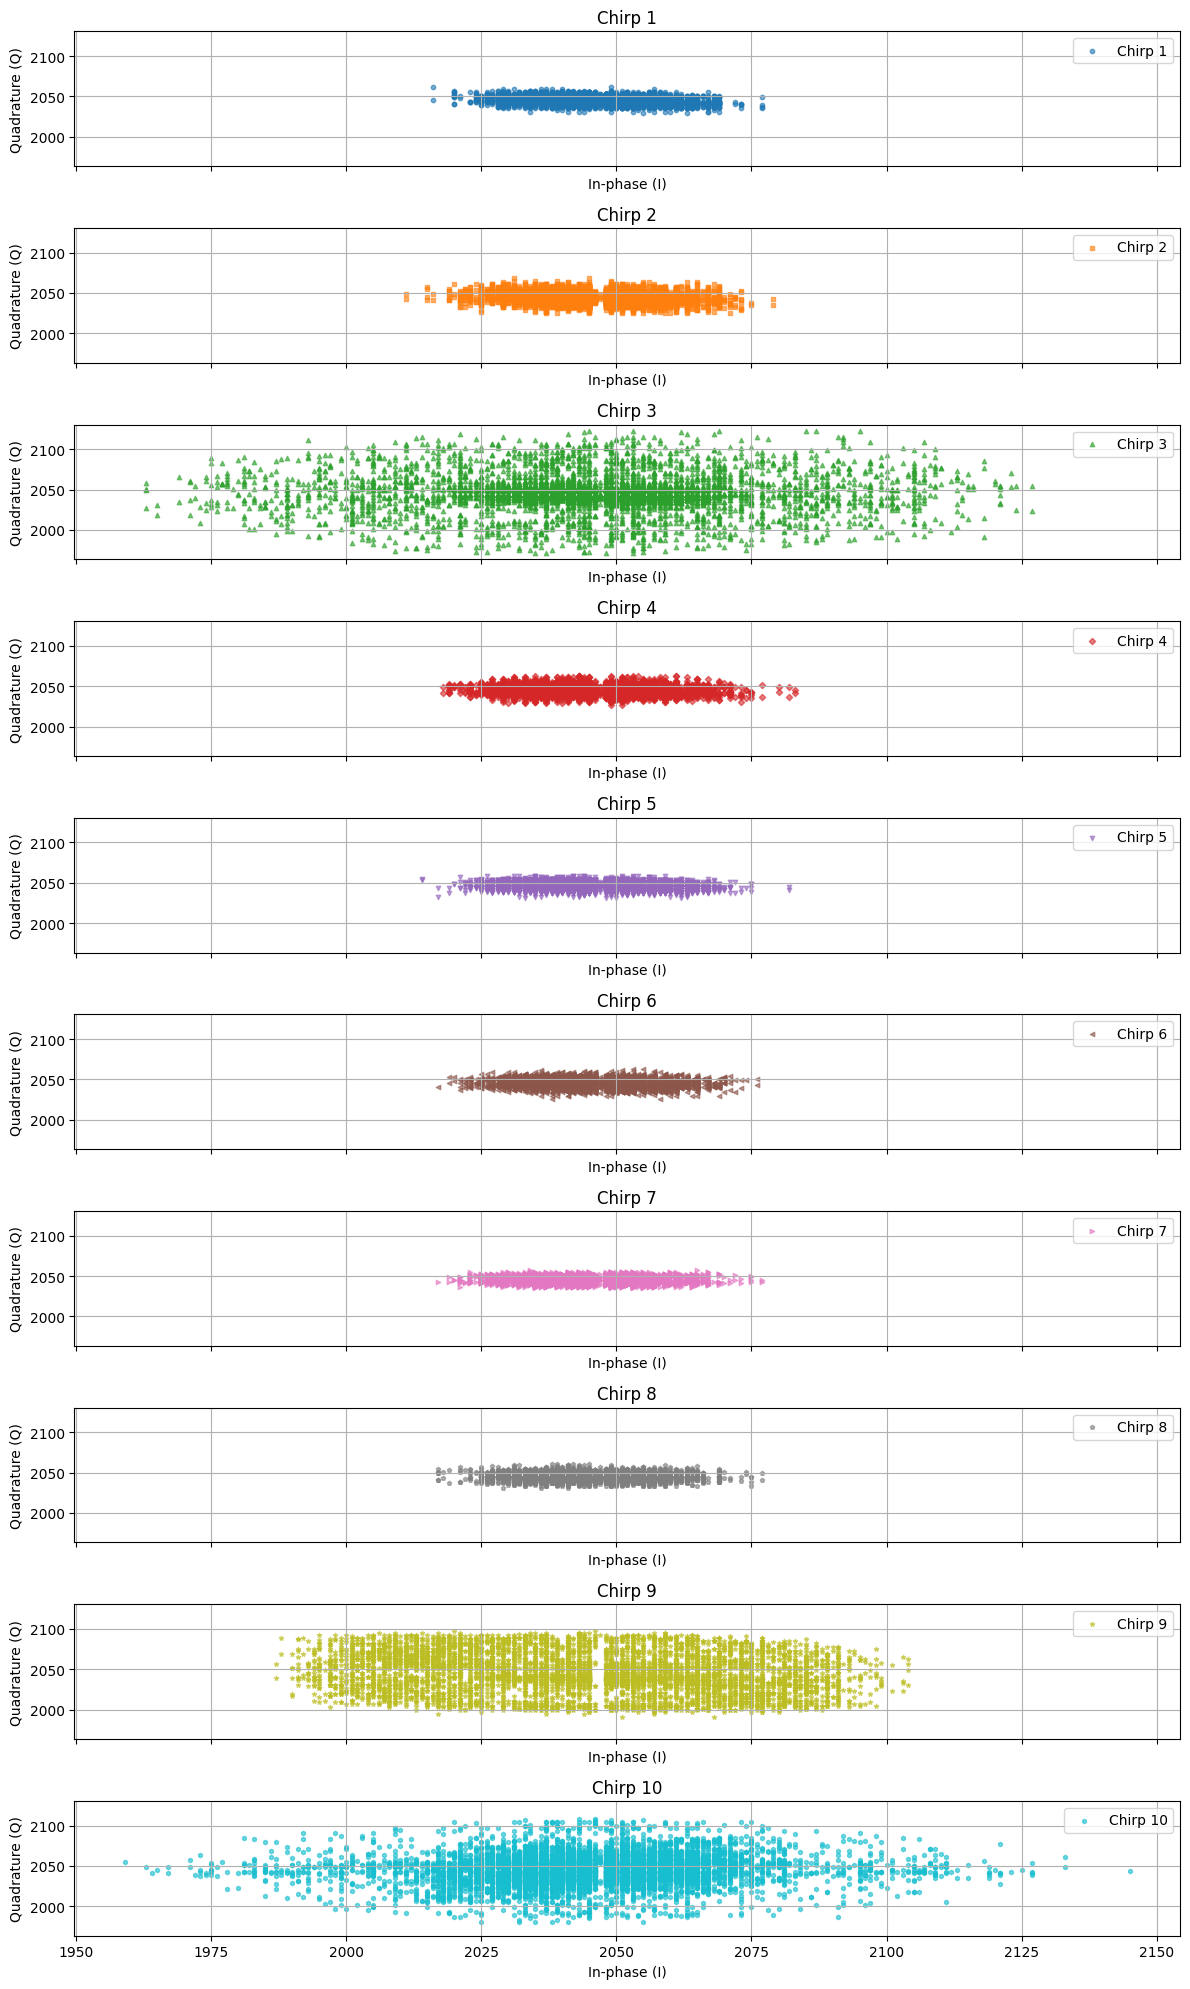

In [70]:
# Load the data from the CSV file
data = pd.read_csv('radar_data5.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Compute the complex signal
s = I + 1j * Q

# Number of samples per chirp (you need to provide this value or calculate it)
num_chirps = 10  # Adjust this value as needed
num_samples_per_chirp = len(s) // num_chirps

# Reshape the complex signal into a 2D array
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Define markers for different chirps
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
colors = plt.get_cmap('tab10', num_chirps)

# Plot each chirp separately in subplots
fig, axs = plt.subplots(num_chirps, 1, figsize=(12, 2*num_chirps), sharex=True, sharey=True)
for chirp_idx in range(num_chirps):
    axs[chirp_idx].scatter(np.real(s[chirp_idx]), np.imag(s[chirp_idx]), marker=markers[chirp_idx % len(markers)], color=colors(chirp_idx), label=f'Chirp {chirp_idx+1}', s=10, alpha=0.6)  # Reduced marker size and added transparency
    axs[chirp_idx].set_xlabel('In-phase (I)')
    axs[chirp_idx].set_ylabel('Quadrature (Q)')
    axs[chirp_idx].set_title(f'Chirp {chirp_idx+1}')
    axs[chirp_idx].legend()
    axs[chirp_idx].grid(True)

plt.tight_layout()
plt.show()

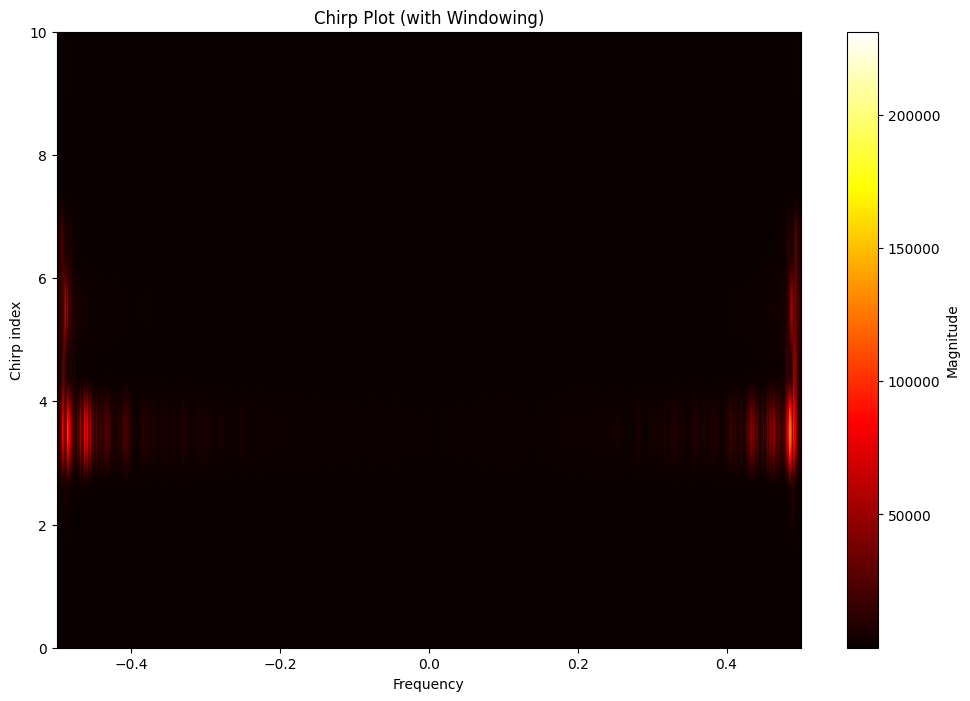

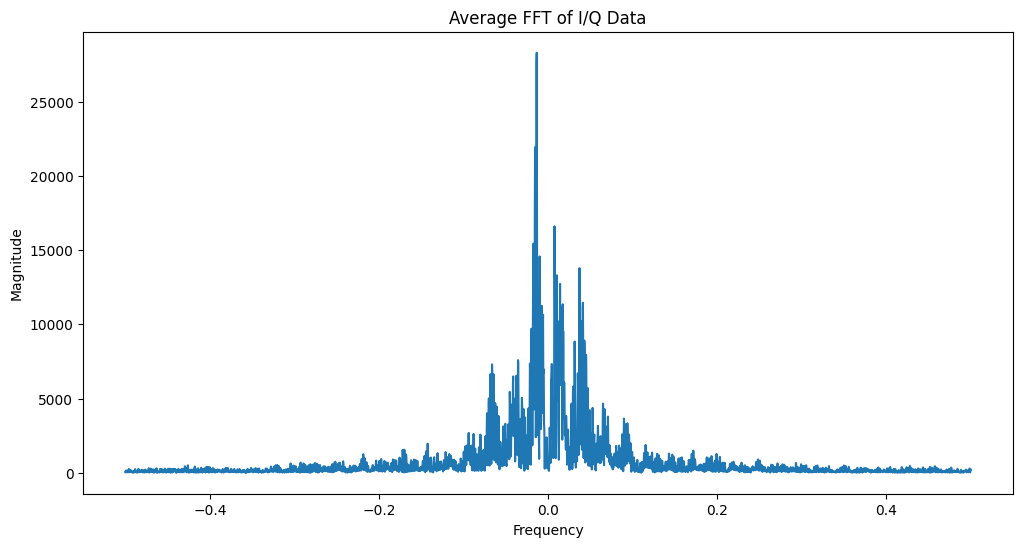

In [76]:
# Load the data from the CSV file
data = pd.read_csv('radar_data1.csv')

# Extract I and Q components
I = data['I'].values
Q = data['Q'].values

# Compute the complex signal
s = I + 1j * Q

# Remove the mean to center the data
s = s - np.mean(s)

# Number of samples per chirp (you need to provide this value or calculate it)
num_chirps = 10  # Adjust this value as needed
num_samples_per_chirp = len(s) // num_chirps

# Reshape the complex signal into a 2D array
s = s[:num_chirps * num_samples_per_chirp]  # Ensure s can be reshaped correctly
s = s.reshape((num_chirps, num_samples_per_chirp))

# Apply a window function (e.g., Hanning window) to reduce spectral leakage
window = np.hanning(num_samples_per_chirp)
s_windowed = s * window

# Apply the FFT along the columns (for each chirp)
range_spectrum = np.fft.fft(s_windowed, axis=1)

# Plot the absolute value of the range spectrum
plt.figure(figsize=(12, 8))
plt.imshow(np.abs(range_spectrum), aspect='auto', cmap='hot', extent=[-0.5, 0.5, 0, num_chirps])
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency')
plt.ylabel('Chirp index')
plt.title('Chirp Plot (with Windowing)')
plt.show()

# Plot the average spectrum across all chirps
plt.figure(figsize=(12, 6))
plt.plot(np.fft.fftshift(np.fft.fftfreq(num_samples_per_chirp)), np.fft.fftshift(np.abs(np.mean(range_spectrum, axis=0))))
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Average FFT of I/Q Data')
plt.show()